<a href="https://colab.research.google.com/github/Kamruzzaman2200/Datamining/blob/main/Occupancy_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install required packages

In [1]:
!pip install --quiet ucimlrepo pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost

#Imports and global settings

import libraries, set plotting and pandas display options, detect optional packages.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os, json, pickle, math
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

# Optional libs
HAS_IMBLEARN = True
HAS_XGBOOST = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception as e:
    HAS_IMBLEARN = False
    print("imblearn not available — will fallback to sklearn resampling.", e)

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
except Exception as e:
    HAS_XGBOOST = False
    print("xgboost not available — XGBoost steps will be skipped.", e)

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)


#Fetch dataset from UCI using your

load official UCI Occupancy dataset using ucimlrepo (your code).

In [3]:
from ucimlrepo import fetch_ucirepo

occupancy_detection = fetch_ucirepo(id=357)
X_raw = occupancy_detection.data.features
y_raw = occupancy_detection.data.targets

print("Metadata keys:", list(occupancy_detection.metadata.keys()))
print("Variables:", occupancy_detection.variables)
print("Features shape:", X_raw.shape, "Target shape:", y_raw.shape)
display(X_raw.head())
display(y_raw.value_counts())

Metadata keys: ['uci_id', 'name', 'repository_url', 'data_url', 'abstract', 'area', 'tasks', 'characteristics', 'num_instances', 'num_features', 'feature_types', 'demographics', 'target_col', 'index_col', 'has_missing_values', 'missing_values_symbol', 'year_of_dataset_creation', 'last_updated', 'dataset_doi', 'creators', 'intro_paper', 'additional_info']
Variables:             name     role        type demographic  \
0             id       ID     Integer        None   
1           date  Feature        Date        None   
2    Temperature  Feature     Integer        None   
3       Humidity  Feature  Continuous        None   
4          Light  Feature     Integer        None   
5            CO2  Feature  Continuous        None   
6  HumidityRatio  Feature  Continuous        None   
7      Occupancy   Target      Binary        None   

                                 description                 units  \
0                                       None                  None   
1             

,date,Temperature,Humidity,Light,CO2,HumidityRatio
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518


,count
Occupancy,
0.0,15810
1.0,4750


#Combine features & target into a DataFrame and initial checks

make a single df DataFrame; parse date if present; show shape and missing counts.

In [5]:
df = X_raw.copy()
df['Occupancy'] = y_raw['Occupancy']  # ensure alignment and 1D assignment

# Parse date column if present
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

print("Combined df shape:", df.shape)
display(df.info())
display(df.head())
print("Missing values per column:\n", df.isna().sum())
print("Target distribution:\n", df['Occupancy'].value_counts())

Combined df shape: (20562, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20562 entries, 0 to 20561
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           20560 non-null  datetime64[ns]
 1   Temperature    20562 non-null  object        
 2   Humidity       20562 non-null  object        
 3   Light          20562 non-null  object        
 4   CO2            20562 non-null  object        
 5   HumidityRatio  20562 non-null  object        
 6   Occupancy      20560 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.1+ MB


None

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529,1.0
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065,1.0
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199,1.0
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175,1.0
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518,1.0


Missing values per column:
 date             2
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        2
dtype: int64
Target distribution:
 Occupancy
0.0    15810
1.0     4750
Name: count, dtype: int64


#Basic cleaning: drop ID-like columns and coerce types

remove index/id-like columns, coerce sensor columns to numeric.

In [6]:
# Drop columns that look like an ID (named 'id' or purely numeric name) but keep date/Occupancy
drop_candidates = [c for c in df.columns if (c.lower() in ('id','index') or c.isdigit()) and c not in ('date','Occupancy')]
for c in drop_candidates:
    df.drop(columns=c, inplace=True)
    print(f"Dropped ID-like column: {c}")

# Coerce remaining sensor columns to numeric (safe)
sensor_cols = [c for c in df.columns if c not in ('date','Occupancy')]
df[sensor_cols] = df[sensor_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing target (defensive)
before = len(df)
df = df.dropna(subset=['Occupancy']).copy()
df['Occupancy'] = df['Occupancy'].astype(int)
after = len(df)
print(f"Dropped {before-after} rows with missing target. New shape: {df.shape}")


Dropped 2 rows with missing target. New shape: (20560, 7)


#EDA: stats and target pie chart

quick descriptive stats and pie chart to check imbalance.

,count,mean,min,25%,50%,75%,max,std
date,20560,2015-02-10 13:42:06.146984448,2015-02-02 14:19:00,2015-02-06 11:05:45,2015-02-10 00:45:30,2015-02-14 19:39:14.249999872,2015-02-18 09:19:00,NaN
Temperature,20560.0,20.906212,19.0,20.2,20.7,21.525,24.408333,1.055315
Humidity,20560.0,27.655925,16.745,24.5,27.29,31.29,39.5,4.982154
Light,20560.0,130.756622,0.0,0.0,0.0,301.0,1697.25,210.430875
CO2,20560.0,690.553276,412.75,460.0,565.416667,804.666667,2076.5,311.201281
HumidityRatio,20560.0,0.004228,0.002674,0.003719,0.004292,0.004832,0.006476,0.000768
Occupancy,20560.0,0.231031,0.0,0.0,0.0,0.0,1.0,0.421503


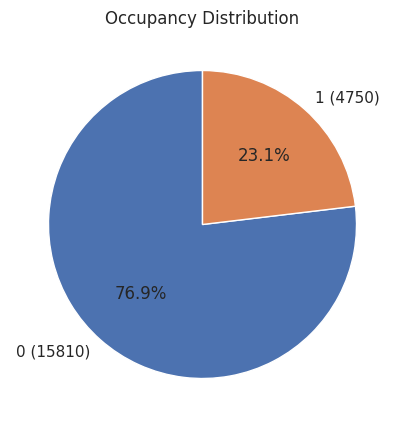

Imbalance ratio (maj/min): 3.328421052631579


In [7]:
display(df.describe().T)
target_counts = df['Occupancy'].value_counts().sort_index()
plt.figure(figsize=(5,5))
plt.pie(target_counts, labels=[f"{idx} ({cnt})" for idx,cnt in target_counts.items()], autopct='%1.1f%%', startangle=90)
plt.title("Occupancy Distribution")
plt.show()
print("Imbalance ratio (maj/min):", target_counts.max() / target_counts.min())


#Missing values imputation and IQR outlier clipping

median imputation and IQR clipping on numeric sensor columns.

In [8]:
numeric_cols = [c for c in df.columns if c not in ('date','Occupancy')]

print("Missing before:", df[numeric_cols].isna().sum().sum())
imputer = SimpleImputer(strategy='median')
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

def clip_iqr(df_, cols, factor=1.5):
    dfc = df_.copy()
    for c in cols:
        q1 = dfc[c].quantile(0.25)
        q3 = dfc[c].quantile(0.75)
        iqr = q3 - q1
        dfc[c] = dfc[c].clip(lower=q1 - factor*iqr, upper=q3 + factor*iqr)
    return dfc

df = clip_iqr(df, numeric_cols, factor=1.5)
print("Missing after impute:", df[numeric_cols].isna().sum().sum())


Missing before: 0
Missing after impute: 0


#Correlation matrix and drop highly correlated features

compute absolute correlation matrix, drop features with correlation > 0.95.

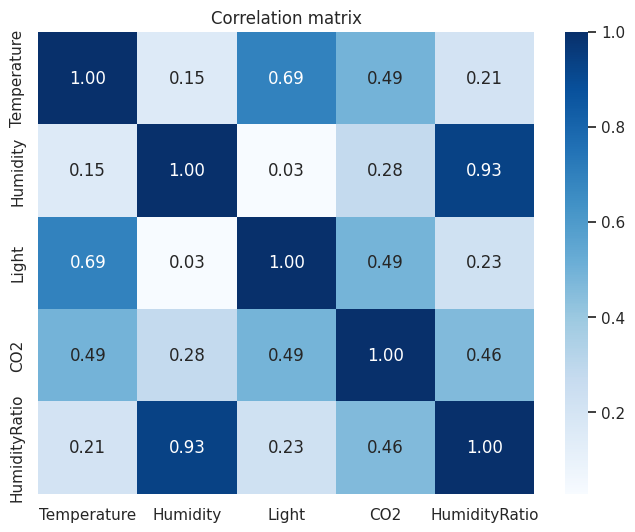

Drop due to high correlation (>0.95): []
Final numeric features: ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']


In [9]:
corr = df[numeric_cols].corr().abs()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues'); plt.title("Correlation matrix")
plt.show()

threshold = 0.95
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]
print("Drop due to high correlation (>%.2f):"%threshold, to_drop)
numeric_final = [c for c in numeric_cols if c not in to_drop]
print("Final numeric features:", numeric_final)


#Feature-engineering knobs (PCA / KBest)

toggle PCA / SelectKBest settings here.

In [10]:
ENABLE_PCA = False
PCA_N_COMPONENTS = 3
ENABLE_KBEST = False
K_BEST = 3

print("PCA:", ENABLE_PCA, "PCA components:", PCA_N_COMPONENTS)
print("KBest:", ENABLE_KBEST, "K:", K_BEST)


PCA: False PCA components: 3
KBest: False K: 3


#Preprocessing pipeline (works with DataFrame column names)

build ColumnTransformer using string column names — safe because X stays a DataFrame.

In [11]:
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_final)], remainder='drop')

post_steps = []
if ENABLE_KBEST:
    post_steps.append(('kbest', SelectKBest(score_func=f_classif, k=K_BEST)))
if ENABLE_PCA:
    post_steps.append(('pca', PCA(n_components=PCA_N_COMPONENTS)))

def make_feature_pipeline():
    steps = [('preproc', preprocessor)]
    steps.extend(post_steps)
    return Pipeline(steps)


#Sampler wrapper & sampler selection (DataFrame-friendly fallback)

wrap SMOTE or fallback to DataFrame resampling.

In [12]:
class SamplerWrapper:
    """
    Simple wrapper with fit_resample(X_df, y_series) that returns balanced DataFrame/Series.
    If imblearn.SMOTE is available, uses it; otherwise resamples minority with sklearn.utils.resample.
    """
    def __init__(self, smote_available=HAS_IMBLEARN):
        self.smote_available = smote_available
        if self.smote_available:
            self.sampler = SMOTE(random_state=42)
        else:
            self.sampler = None

    def fit_resample(self, X_df, y_series):
        if self.smote_available:
            Xr, yr = self.sampler.fit_resample(X_df, y_series)
            Xr = pd.DataFrame(Xr, columns=X_df.columns)
            yr = pd.Series(yr, name=y_series.name)
            return Xr, yr
        else:
            df_tmp = X_df.copy()
            df_tmp['target'] = y_series.values
            maj = df_tmp[df_tmp['target']==df_tmp['target'].mode()[0]]
            min_ = df_tmp[df_tmp['target']!=df_tmp['target'].mode()[0]]
            if len(min_)==0 or len(maj)==len(min_):
                return X_df, y_series
            min_up = resample(min_, replace=True, n_samples=len(maj), random_state=42)
            df_bal = pd.concat([maj, min_up]).sample(frac=1, random_state=42)
            yr = df_bal['target']
            Xr = df_bal.drop(columns=['target'])
            return Xr.reset_index(drop=True), yr.reset_index(drop=True)

sampler_wrapper = SamplerWrapper(smote_available=HAS_IMBLEARN)


#Model zoo and a function to build pipelines (DataFrame-safe)

creates a pipeline builder that accepts classifier and whether to use imblearn pipeline.

In [21]:
def make_pipeline_for(clf, use_imblearn_sampler=False):
    """
    If use_imblearn_sampler True and imblearn installed -> returns an ImbPipeline(features -> SMOTE -> clf).
    Otherwise returns sklearn Pipeline(features -> clf).
    Pipelines expect DataFrame X (ColumnTransformer uses column names).
    """
    # Get the steps for feature processing. make_feature_pipeline() returns an sklearn.pipeline.Pipeline.
    # We need to extract its individual steps for use in ImbPipeline.
    feature_pipeline_object = make_feature_pipeline()
    feature_steps = feature_pipeline_object.steps

    if use_imblearn_sampler and HAS_IMBLEARN:
        # Create an ImbPipeline by concatenating individual feature steps, SMOTE, and classifier.
        # All steps in ImbPipeline must be base estimators or transformers, not nested Pipelines.
        all_steps = list(feature_steps) + [('smote', SMOTE(random_state=42)), ('clf', clf)]
        return ImbPipeline(all_steps)
    else:
        # Create a standard sklearn Pipeline with feature steps and classifier.
        all_steps = list(feature_steps) + [('clf', clf)]
        return Pipeline(all_steps)

model_zoo = {
    'NaiveBayes': GaussianNB(),
    'Logistic': LogisticRegression(max_iter=2000, solver='liblinear'),
    'DecisionTree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVC': SVC(probability=True, kernel='rbf', random_state=42),
    'Perceptron': Perceptron(max_iter=1000, random_state=42)
}
if HAS_XGBOOST:
    model_zoo['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

#Train/test split (keep DataFrames) and optional resampling of training set

split while preserving DataFrame type; apply fallback resampling to training set if imblearn absent.

In [22]:
X = df[numeric_final].copy()         # <-- DataFrame (important)
y = df['Occupancy'].copy()           # <-- Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("X_train type:", type(X_train), "X_test type:", type(X_test))
print("Class counts before balancing:", Counter(y_train))

# If imblearn not available, apply fallback resampling to training DataFrame
if not HAS_IMBLEARN:
    X_train, y_train = sampler_wrapper.fit_resample(X_train.reset_index(drop=True), y_train.reset_index(drop=True))
    print("Applied fallback balancing. Class counts after:", Counter(y_train))
else:
    print("imblearn available; will use SMOTE inside pipelines if requested.")


X_train type: <class 'pandas.core.frame.DataFrame'> X_test type: <class 'pandas.core.frame.DataFrame'>
Class counts before balancing: Counter({0: 12648, 1: 3800})
imblearn available; will use SMOTE inside pipelines if requested.


#CV helpers (safe ROC handling)

helpers to compute safe predict_proba/decision and cross-validate pipelines with DataFrame inputs.

In [23]:
def safe_predict_scores(est, X_df):
    try:
        return est.predict_proba(X_df)[:,1]
    except Exception:
        try:
            return est.decision_function(X_df)
        except Exception:
            return None

def cross_validate_pipeline(pipe, X_df, y_series, cv=5, scoring=('accuracy','roc_auc')):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    res = cross_validate(pipe, X_df, y_series, scoring=scoring, cv=skf, n_jobs=-1, return_train_score=False)
    return {k: float(np.mean(v)) for k,v in res.items()}


#Quick cross-validation of model zoo (fixed)

evaluate each model using pipelines that accept DataFrames. This fixes the earlier ValueError.

In [24]:
if HAS_IMBLEARN:
    from imblearn.pipeline import Pipeline as ImbPipeline
else:
    ImbPipeline = None

def build_safe_pipeline(clf, use_smote=False):
    """
    Construct a pipeline that is safe for ImbPipeline:
    - first step: preprocessor (ColumnTransformer)
    - optional: SelectKBest / PCA each as individual steps (not wrapped in a Pipeline)
    - optional: SMOTE step (only used when HAS_IMBLEARN and use_smote True)
    - final: classifier
    Returns either ImbPipeline (if SMOTE requested and available) or sklearn Pipeline.
    """
    # Start with the ColumnTransformer (preprocessor defined earlier in Cell 10)
    steps = [('preproc', preprocessor)]
    # Add post-processing steps (if enabled) as individual steps
    if ENABLE_KBEST:
        steps.append(('kbest', SelectKBest(score_func=f_classif, k=K_BEST)))
    if ENABLE_PCA:
        steps.append(('pca', PCA(n_components=PCA_N_COMPONENTS)))
    # If using SMOTE and imblearn is available, append SMOTE as a step inside ImbPipeline
    if use_smote and HAS_IMBLEARN:
        # Compose ImbPipeline from the transformer steps + smote + classifier
        imb_steps = list(steps) + [('smote', SMOTE(random_state=42)), ('clf', clf)]
        return ImbPipeline(imb_steps)
    else:
        # Use a normal sklearn Pipeline (no SMOTE inside)
        skl_steps = list(steps) + [('clf', clf)]
        return Pipeline(skl_steps)

# Now perform CV for each baseline model using the safe pipeline builder
cv_results = {}
for name, clf in model_zoo.items():
    print(f"Evaluating {name} ...")
    # Decide whether to apply SMOTE inside pipeline during CV (toggle as desired)
    use_smote_in_cv = HAS_IMBLEARN  # set to False if you don't want SMOTE applied inside CV
    try:
        pipe = build_safe_pipeline(clf, use_smote=use_smote_in_cv)
        # Run stratified CV using DataFrame X_train and Series y_train
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        res = cross_validate(pipe, X_train, y_train, scoring=['accuracy', 'roc_auc'], cv=skf, n_jobs=-1, return_train_score=False)
        result_summary = {k: float(v.mean()) for k, v in res.items()}
        cv_results[name] = result_summary
        print(f"  CV results: {result_summary}")
    except Exception as e:
        # If something still fails, print the exception and continue
        print(f"  CV failed for {name}: {e}")

# Optionally, display cv_results dictionary
print("\nAll CV results (summary):")
for k,v in cv_results.items():
    print(f" - {k}: {v}")

Evaluating NaiveBayes ...
  CV results: {'fit_time': 0.03905935287475586, 'score_time': 0.019150304794311523, 'test_accuracy': 0.9665001418562935, 'test_roc_auc': 0.9941788180344945}
Evaluating Logistic ...
  CV results: {'fit_time': 0.061849784851074216, 'score_time': 0.020156002044677733, 'test_accuracy': 0.9882050974002871, 'test_roc_auc': 0.9947930720924566}
Evaluating DecisionTree ...
  CV results: {'fit_time': 0.10442018508911133, 'score_time': 0.014849281311035157, 'test_accuracy': 0.9895427606620946, 'test_roc_auc': 0.9939330077940081}
Evaluating KNN ...
  CV results: {'fit_time': 0.049804162979125974, 'score_time': 0.06681771278381347, 'test_accuracy': 0.992704206062208, 'test_roc_auc': 0.9968929271501139}
Evaluating RandomForest ...
  CV results: {'fit_time': 2.8979207038879395, 'score_time': 0.11147723197937012, 'test_accuracy': 0.9920962478779314, 'test_roc_auc': 0.999064430101976}
Evaluating SVC ...
  CV results: {'fit_time': 3.878087854385376, 'score_time': 0.206083393096

#Hyperparameter tuning (Randomized + Grid) — DataFrame safe

run RandomizedSearchCV / GridSearchCV with pipelines that accept DataFrames.

In [25]:
tuning_results = {}

# RandomForest randomized search
rf_pipe = make_pipeline_for(RandomForestClassifier(random_state=42, n_jobs=-1), use_imblearn_sampler=HAS_IMBLEARN)
rf_param_dist = {'clf__n_estimators':[50,100,200], 'clf__max_depth':[None,5,10], 'clf__min_samples_split':[2,5,10]}
rs_rf = RandomizedSearchCV(rf_pipe, rf_param_dist, n_iter=6, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
rs_rf.fit(X_train, y_train)
tuning_results['RandomForest'] = {'best_score': float(rs_rf.best_score_), 'best_params': rs_rf.best_params_}
print("RF best:", tuning_results['RandomForest'])

# Logistic (Grid)
lr_pipe = make_pipeline_for(LogisticRegression(max_iter=2000, solver='liblinear'), use_imblearn_sampler=HAS_IMBLEARN)
lr_param_grid = {'clf__C':[0.01,0.1,1,10], 'clf__penalty':['l1','l2']}
gs_lr = GridSearchCV(lr_pipe, lr_param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
gs_lr.fit(X_train, y_train)
tuning_results['Logistic'] = {'best_score': float(gs_lr.best_score_), 'best_params': gs_lr.best_params_}
print("Logistic best:", tuning_results['Logistic'])

# SVC randomized
svc_pipe = make_pipeline_for(SVC(probability=True, random_state=42), use_imblearn_sampler=HAS_IMBLEARN)
svc_param_dist = {'clf__C':[0.1,1,10], 'clf__kernel':['rbf','linear'], 'clf__gamma':['scale','auto']}
rs_svc = RandomizedSearchCV(svc_pipe, svc_param_dist, n_iter=6, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
rs_svc.fit(X_train, y_train)
tuning_results['SVC'] = {'best_score': float(rs_svc.best_score_), 'best_params': rs_svc.best_params_}
print("SVC best:", tuning_results['SVC'])

# KNN randomized
knn_pipe = make_pipeline_for(KNeighborsClassifier(), use_imblearn_sampler=HAS_IMBLEARN)
knn_param_dist = {'clf__n_neighbors':[3,5,7,9], 'clf__weights':['uniform','distance']}
rs_knn = RandomizedSearchCV(knn_pipe, knn_param_dist, n_iter=6, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
rs_knn.fit(X_train, y_train)
tuning_results['KNN'] = {'best_score': float(rs_knn.best_score_), 'best_params': rs_knn.best_params_}
print("KNN best:", tuning_results['KNN'])

# XGBoost if available
if HAS_XGBOOST:
    xgb_pipe = make_pipeline_for(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), use_imblearn_sampler=HAS_IMBLEARN)
    xgb_param_dist = {'clf__n_estimators':[50,100,200], 'clf__max_depth':[3,5,7], 'clf__learning_rate':[0.01,0.1,0.2]}
    rs_xgb = RandomizedSearchCV(xgb_pipe, xgb_param_dist, n_iter=6, cv=3, scoring='roc_auc', random_state=42, n_jobs=-1)
    rs_xgb.fit(X_train, y_train)
    tuning_results['XGBoost'] = {'best_score': float(rs_xgb.best_score_), 'best_params': rs_xgb.best_params_}
    print("XGBoost best:", tuning_results['XGBoost'])

# Save tuning summary
with open(ARTIFACT_DIR / "tuning_results.json","w") as f:
    json.dump(tuning_results, f, indent=2)
print("Saved tuning_results.json")


RF best: {'best_score': 0.9988467471274539, 'best_params': {'clf__n_estimators': 50, 'clf__min_samples_split': 5, 'clf__max_depth': 10}}
Logistic best: {'best_score': 0.9948740258645893, 'best_params': {'clf__C': 0.01, 'clf__penalty': 'l2'}}
SVC best: {'best_score': 0.9953689464184675, 'best_params': {'clf__kernel': 'rbf', 'clf__gamma': 'auto', 'clf__C': 10}}
KNN best: {'best_score': 0.99747208709266, 'best_params': {'clf__weights': 'distance', 'clf__n_neighbors': 9}}
XGBoost best: {'best_score': 0.9988202547065294, 'best_params': {'clf__n_estimators': 100, 'clf__max_depth': 5, 'clf__learning_rate': 0.1}}
Saved tuning_results.json


#Build stacking ensemble (uses tuned estimators)

create stacking classifier using best estimators extracted from searches (they are pipelines).

In [26]:
def extract_clf(pipe_or_search):
    # returns the inner classifier object suitable for StackingClassifier
    best = pipe_or_search.best_estimator_ if hasattr(pipe_or_search,'best_estimator_') else pipe_or_search
    # best is a Pipeline; extract step named 'clf'
    if hasattr(best, 'named_steps') and 'clf' in best.named_steps:
        return best.named_steps['clf']
    return best

rf_est = extract_clf(rs_rf)
lr_est = extract_clf(gs_lr)
svc_est = extract_clf(rs_svc)

stacking_estimators = [('rf', rf_est), ('lr', lr_est), ('svc', svc_est)]
stack = StackingClassifier(estimators=stacking_estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)

# Wrap stacking into a pipeline with preprocessing (no sampler here, training data already balanced if needed)
stack_pipe = Pipeline([('features', make_feature_pipeline()), ('clf', stack)])
stack_cv_res = cross_validate_pipeline(stack_pipe, X_train, y_train, cv=5)
print("Stacking CV results:", stack_cv_res)


Stacking CV results: {'fit_time': 17.59435749053955, 'score_time': 0.26114964485168457, 'test_accuracy': 0.992461100416697, 'test_roc_auc': 0.9989652064345664}


#Learning curves for selected models

draw learning curves for tuned RandomForest and SVC pipelines (they accept DataFrames).

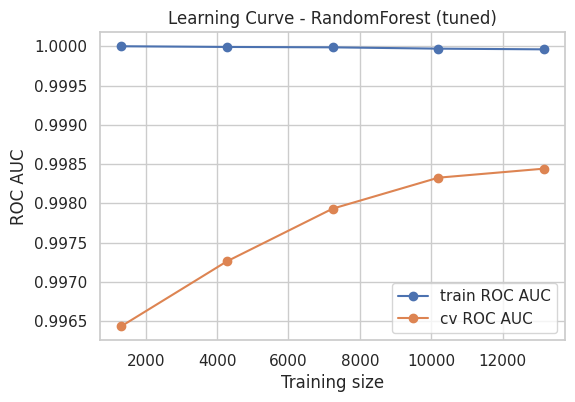

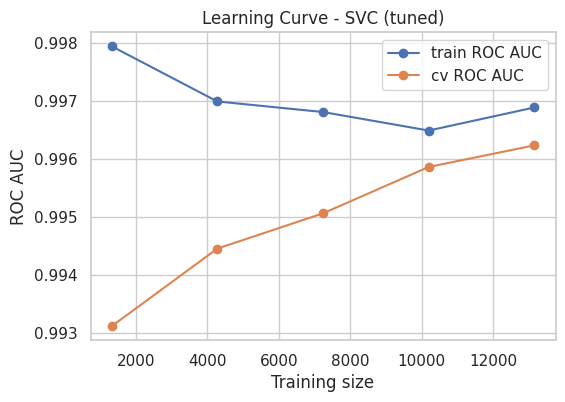

In [27]:
def plot_learning(pipe, X_df, y_series, title):
    plt.figure(figsize=(6,4))
    train_sizes, train_scores, test_scores = learning_curve(pipe, X_df, y_series, cv=5, scoring='roc_auc', n_jobs=1, train_sizes=np.linspace(.1,1.0,5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='train ROC AUC')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='cv ROC AUC')
    plt.title(title); plt.xlabel('Training size'); plt.ylabel('ROC AUC'); plt.legend(); plt.grid(True); plt.show()

# Best pipelines found
best_rf_pipe = rs_rf.best_estimator_
best_svc_pipe = rs_svc.best_estimator_

plot_learning(best_rf_pipe, X_train, y_train, "Learning Curve - RandomForest (tuned)")
plot_learning(best_svc_pipe, X_train, y_train, "Learning Curve - SVC (tuned)")


#Evaluate tuned models on the test set (safe handling)

fit best pipelines (if needed) and evaluate accuracy, mcr, confusion matrix, ROC AUC.

In [28]:
def evaluate_pipeline(pipe, X_tr, y_tr, X_te, y_te, name):
    # fit on full training set
    best = pipe.best_estimator_ if hasattr(pipe, 'best_estimator_') else pipe
    best.fit(X_tr, y_tr)
    y_pred = best.predict(X_te)
    y_score = None
    try:
        y_score = best.predict_proba(X_te)[:,1]
    except Exception:
        try:
            y_score = best.decision_function(X_te)
        except Exception:
            y_score = None
    acc = accuracy_score(y_te, y_pred); mcr = 1-acc
    cm = confusion_matrix(y_te, y_pred)
    roc = roc_auc_score(y_te, y_score) if y_score is not None else float('nan')
    print(f"{name}: accuracy={acc:.4f}, mcr={mcr:.4f}, roc_auc={roc:.4f}")
    print("Confusion matrix:\n", cm)
    return {'accuracy':acc, 'mcr':mcr, 'roc_auc':roc, 'confusion_matrix':cm.tolist()}

evaluations = {}
evaluations['RandomForest'] = evaluate_pipeline(rs_rf.best_estimator_, X_train, y_train, X_test, y_test, 'RandomForest (tuned)')
evaluations['Logistic'] = evaluate_pipeline(gs_lr.best_estimator_, X_train, y_train, X_test, y_test, 'Logistic (tuned)')
evaluations['SVC'] = evaluate_pipeline(rs_svc.best_estimator_, X_train, y_train, X_test, y_test, 'SVC (tuned)')
evaluations['KNN'] = evaluate_pipeline(rs_knn.best_estimator_, X_train, y_train, X_test, y_test, 'KNN (tuned)')
if HAS_XGBOOST:
    evaluations['XGBoost'] = evaluate_pipeline(rs_xgb.best_estimator_, X_train, y_train, X_test, y_test, 'XGBoost (tuned)')


RandomForest (tuned): accuracy=0.9903, mcr=0.0097, roc_auc=0.9988
Confusion matrix:
 [[3133   29]
 [  11  939]]
Logistic (tuned): accuracy=0.9861, mcr=0.0139, roc_auc=0.9944
Confusion matrix:
 [[3108   54]
 [   3  947]]
SVC (tuned): accuracy=0.9900, mcr=0.0100, roc_auc=0.9967
Confusion matrix:
 [[3124   38]
 [   3  947]]
KNN (tuned): accuracy=0.9920, mcr=0.0080, roc_auc=0.9965
Confusion matrix:
 [[3133   29]
 [   4  946]]
XGBoost (tuned): accuracy=0.9900, mcr=0.0100, roc_auc=0.9987
Confusion matrix:
 [[3130   32]
 [   9  941]]


#ROC curves for tuned models

plot ROC curves for models that expose scores.

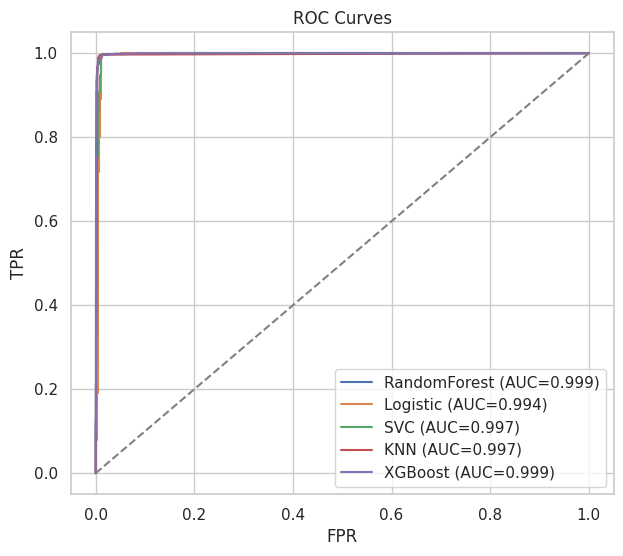

In [29]:
plt.figure(figsize=(7,6))
for name, pipe in [('RandomForest', rs_rf.best_estimator_), ('Logistic', gs_lr.best_estimator_), ('SVC', rs_svc.best_estimator_), ('KNN', rs_knn.best_estimator_)] + ([('XGBoost', rs_xgb.best_estimator_)] if HAS_XGBOOST else []):
    try:
        est = pipe.best_estimator_ if hasattr(pipe, 'best_estimator_') else pipe
        est.fit(X_train, y_train)
        y_score = None
        try:
            y_score = est.predict_proba(X_test)[:,1]
        except Exception:
            try:
                y_score = est.decision_function(X_test)
            except Exception:
                y_score = None
        if y_score is None:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
    except Exception as e:
        print("ROC failed for", name, e)

plt.plot([0,1],[0,1],'--', color='gray'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend(); plt.grid(True); plt.show()


#Final ensembles (voting & stacking) and evaluation

create soft/hard voting ensembles and a final stacked classifier, evaluate each.

In [30]:
# Extract fitted inner classifier objects from pipelines for building ensemble estimators
def extract_inner(pipe):
    p = pipe.best_estimator_ if hasattr(pipe,'best_estimator_') else pipe
    if hasattr(p, 'named_steps') and 'clf' in p.named_steps:
        return p.named_steps['clf']
    return p

f_rf = extract_inner(rs_rf)
f_lr = extract_inner(gs_lr)
f_svc = extract_inner(rs_svc)

voters = [('rf', f_rf), ('lr', f_lr), ('svc', f_svc)]
voting_soft = VotingClassifier(estimators=voters, voting='soft', n_jobs=-1)
voting_hard = VotingClassifier(estimators=voters, voting='hard', n_jobs=-1)

# Wrap into pipelines with the feature preprocessor
voting_soft_pipe = Pipeline([('features', make_feature_pipeline()), ('clf', voting_soft)])
voting_hard_pipe = Pipeline([('features', make_feature_pipeline()), ('clf', voting_hard)])

# Fit and evaluate
voting_soft_pipe.fit(X_train, y_train)
evaluations['Voting-Soft'] = evaluate_pipeline(voting_soft_pipe, X_train, y_train, X_test, y_test, 'Voting Soft')

voting_hard_pipe.fit(X_train, y_train)
evaluations['Voting-Hard'] = evaluate_pipeline(voting_hard_pipe, X_train, y_train, X_test, y_test, 'Voting Hard')

# Final stacking ensemble (using tuned inner classifiers)
final_estimators = [('rf', f_rf), ('svc', f_svc), ('lr', f_lr)]
final_stack = StackingClassifier(estimators=final_estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
final_stack_pipe = Pipeline([('features', make_feature_pipeline()), ('clf', final_stack)])
final_stack_pipe.fit(X_train, y_train)
evaluations['FinalStack'] = evaluate_pipeline(final_stack_pipe, X_train, y_train, X_test, y_test, 'Final Stacking')


Voting Soft: accuracy=0.9900, mcr=0.0100, roc_auc=0.9988
Confusion matrix:
 [[3125   37]
 [   4  946]]
Voting Hard: accuracy=0.9895, mcr=0.0105, roc_auc=nan
Confusion matrix:
 [[3124   38]
 [   5  945]]
Final Stacking: accuracy=0.9903, mcr=0.0097, roc_auc=0.9990
Confusion matrix:
 [[3135   27]
 [  13  937]]


#Save artifacts and final summary

save cleaned data, tuned pipelines, evaluations, and predictions to artifacts/.

In [31]:
df.to_csv(ARTIFACT_DIR / "occupancy_cleaned_final.csv", index=False)
pickle.dump(rs_rf.best_estimator_, open(ARTIFACT_DIR / "best_random_forest_pipeline.pkl","wb"))
pickle.dump(gs_lr.best_estimator_, open(ARTIFACT_DIR / "best_logistic_pipeline.pkl","wb"))
pickle.dump(rs_svc.best_estimator_, open(ARTIFACT_DIR / "best_svc_pipeline.pkl","wb"))
pickle.dump(rs_knn.best_estimator_, open(ARTIFACT_DIR / "best_knn_pipeline.pkl","wb"))
pickle.dump(voting_soft_pipe, open(ARTIFACT_DIR / "voting_soft_pipeline.pkl","wb"))
pickle.dump(final_stack_pipe, open(ARTIFACT_DIR / "final_stack_pipeline.pkl","wb"))

with open(ARTIFACT_DIR / "tuning_results.json","w") as f:
    json.dump(tuning_results, f, indent=2)
with open(ARTIFACT_DIR / "evaluations.json","w") as f:
    json.dump(evaluations, f, indent=2)

# Save predictions for best model by roc_auc
best_model_name = max(evaluations.items(), key=lambda kv: (kv[1]['roc_auc'] if not math.isnan(kv[1]['roc_auc']) else -1))[0]
print("Best model by ROC AUC:", best_model_name)
# Map name to pipeline
name_to_pipeline = {
    'RandomForest': rs_rf.best_estimator_,
    'Logistic': gs_lr.best_estimator_,
    'SVC': rs_svc.best_estimator_,
    'KNN': rs_knn.best_estimator_,
    'Voting-Soft': voting_soft_pipe,
    'Voting-Hard': voting_hard_pipe,
    'FinalStack': final_stack_pipe
}
best_pipe = name_to_pipeline.get(best_model_name, rs_rf.best_estimator_)
best_pipe.fit(X_train, y_train)
preds = best_pipe.predict(X_test)
probs = None
try:
    probs = best_pipe.predict_proba(X_test)[:,1]
except Exception:
    try:
        probs = best_pipe.decision_function(X_test)
    except Exception:
        probs = None

pred_df = pd.DataFrame({"true": y_test.values, "pred": preds, "prob": probs})
pred_df.to_csv(ARTIFACT_DIR / "final_test_predictions.csv", index=False)

print("Saved artifacts to", ARTIFACT_DIR.resolve())
print("Done.")


Best model by ROC AUC: FinalStack
Saved artifacts to /content/artifacts
Done.
